In [1]:
import midynet
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

In [66]:
def SISSusceptibility(x):
    n = x.sum(-1)
    return (np.mean(n**2) - np.mean(n)**2) / np.mean(n)

def GlauberSusceptibility(x):
    x[x == 0] = -1
    n = np.abs(x.mean(-1))
    return (np.mean(n**2) - np.mean(n)**2) / np.mean(n)

def CowanSusceptibility(x):
    x[x == 0] = -1
    n = np.abs(x.mean(-1))
    return (np.mean(n**2) - np.mean(n)**2)

susceptiblityFunctions = {
    "glauber": GlauberSusceptibility,
    "ising": GlauberSusceptibility,
    "cowan": CowanSusceptibility,
    "sis": SISSusceptibility
}


def collectSusceptibility(cfg):
    suscFunc = susceptiblityFunctions[cfg.dynamics.name]
    graph = midynet.config.RandomGraphFactory.build(cfg.graph)
    dynamics = midynet.config.DynamicsFactory.build(cfg.dynamics)
    dynamics.set_random_graph(graph.get_wrap())
    dynamics.sample()
    x = np.array(dynamics.get_past_states())
    return suscFunc(x)
    
    
def searchThresholds(cfg, paramName, paramMin, paramMax, numPoints=10, delta=1, tol=1e-3, numSamples=10, verbose=1):
    paramScan = np.linspace(paramMin, paramMax, numPoints)
    diff = np.inf

    history = {}
    while(diff > tol):
        susceptibility = []
        if verbose > 0:
            print(f"Scaning params {paramScan}")
        for p in paramScan:
            cfg.dynamics.set_value(paramName, p)
            s = []
            if verbose == 1:
                print(p)
            with mp.Pool(4) as pool:
                s = pool.map(collectSusceptibility, [cfg] * numSamples)
#             for i in range(numSamples):
#                 s.append(collectSusceptibility(cfg))
            susceptibility.append(np.mean(s))
    
        for s, p in zip(susceptibility, paramScan):
            if p in history:
                history[p].append(s)
            else:
                history[p] = [s]
#         plt.plot(susceptibility)
#         plt.show()
        maxIndex = np.argmax(susceptibility)
        paramMin = paramScan[maxIndex - delta]
        paramMax = paramScan[maxIndex + delta]
        paramScan = np.linspace(paramMin, paramMax, numPoints)
        diff = paramMax - paramMin
        if verbose > 0:
            print(f"Current history: {history}")
            print(f"Current diff: {diff}")
    return history, paramScan[np.argmax(susceptibility)]

def plotThresholdSearch(ax, history, threshold=None, paramName=f"Coupling"):
    x = []; y = []

    for k, v in history.items():
        x.append(k)
        y.append(np.mean(v))
    indices = np.argsort(x)
    x = np.array(x)[indices]
    y = np.array(y)[indices]
    ax.plot(x, y, "o-")
    if threshold is not None:
        ax.axvline(threshold, linestyle="--", color="grey")
    ax.plot(threshold, linestyle="--", color="grey")
    ax.set_xlabel(paramName)
    ax.set_ylabel(r"Susceptibility $\chi$")
    ax.set_ylim([y.min(), y.max() * 1.1])
    return ax

def showThresholdSearch(history, threshold=None, paramName=f"Coupling"):
    plotThresholdSearch(plt.gca(), history, threshold=threshold,paramName=paramName)


In [55]:
histories = {}
thresholds = {}

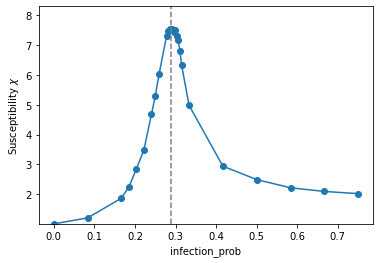

In [56]:
config = midynet.config.ExperimentConfig.default("susceptiblity", "sis", "nbinom_cm")

config.graph.set_value("size", 500)
config.graph.edge_count.set_value("state", 1250)
config.graph.set_value("heterogeneity", 1)

config.dynamics.set_value("num_steps", 1000)
config.dynamics.set_value("recovery_prob", 0.5)
config.dynamics.set_value("auto_activation_prob", 0.001)
config.dynamics.set_value("num_active", 1)

histories["sis"], thresholds["sis"] = searchThresholds(config, "infection_prob", 0, 0.75, tol=0.01, numSamples=100, verbose=0)
showThresholdSearch(histories["sis"], thresholds["sis"], f"infection_prob")

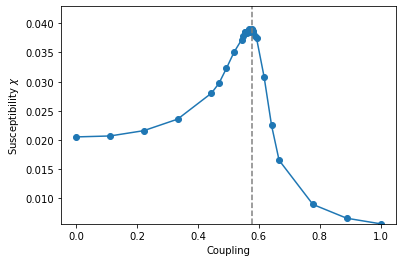

In [57]:
config = midynet.config.ExperimentConfig.default("susceptiblity", "ising", "nbinom_cm")

config.graph.set_value("size", 500)
config.graph.edge_count.set_value("state", 1250)
config.graph.set_value("heterogeneity", 1)

config.dynamics.set_value("num_steps", 1000)

histories["ising"], thresholds["ising"] = searchThresholds(config, "coupling", 0, 1, delta=1, tol=0.01, numSamples=100, verbose=0)

showThresholdSearch(histories["ising"], thresholds["ising"], f"Coupling")


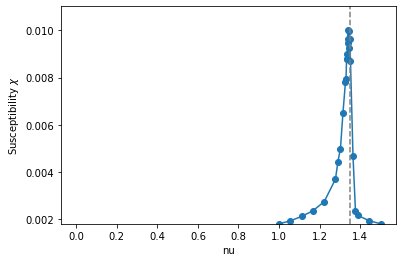

In [58]:
config = midynet.config.ExperimentConfig.default("susceptiblity", "cowan", "nbinom_cm")

config.graph.set_value("size", 500)
config.graph.edge_count.set_value("state", 1250)
config.graph.set_value("heterogeneity", 1)

config.dynamics.set_value("num_steps", 1000)
config.dynamics.set_value("num_active", config.graph.size)

histories["cowan"], thresholds["cowan"] = searchThresholds(config, "nu", 1., 1.5, delta=1, tol=0.01, numSamples=100, verbose=0)

showThresholdSearch(histories["cowan"], thresholds["cowan"], f"nu")

In [75]:
import json

data = dict(histories=histories, thresholds=thresholds)
with open("thresholds.json", "w") as f:
    json.dump(data, f )
    

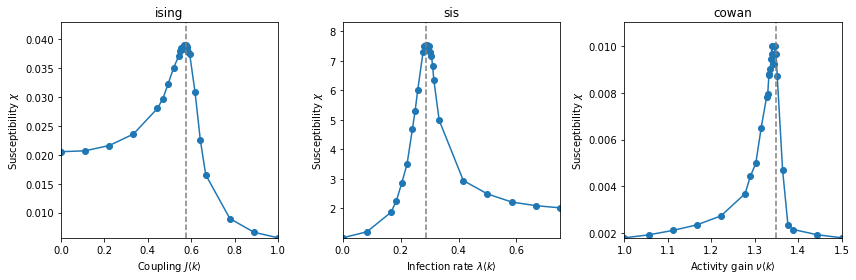

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

xlabels = {
    "ising": r"Coupling $J\langle k \rangle$",
    "sis": r"Infection rate $\lambda \langle k \rangle$",
    "cowan": r"Activity gain $\nu\langle k \rangle$"}

for i, k in enumerate(xlabels.keys()):
    plotThresholdSearch(ax[i], histories[k], thresholds[k], xlabels[k])
    ax[i].set_title(k)
    x = list(histories[k].keys())
    ax[i].set_xlim([min(x), max(x)])

fig.tight_layout()
plt.show()